<a href="https://colab.research.google.com/github/jaschn/DeepLearningProject/blob/main/Comparisons/ColorizingWithInstance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install -U torch==1.8 torchvision==0.9 -f https://download.pytorch.org/whl/cu101/torch_stable.html
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
#!pip install dominate==2.4.0
#!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.8 ; cuda:  cu101


In [6]:
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import cv2

# downloading only part of dataset
from os.path import join, isfile, isdir
from os import listdir
import os

#!pip install fastai --upgrade
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [7]:
import glob
import time
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
    
paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(555)
paths_subset = np.random.choice(paths, 5, replace=False) # choosing 100 images random

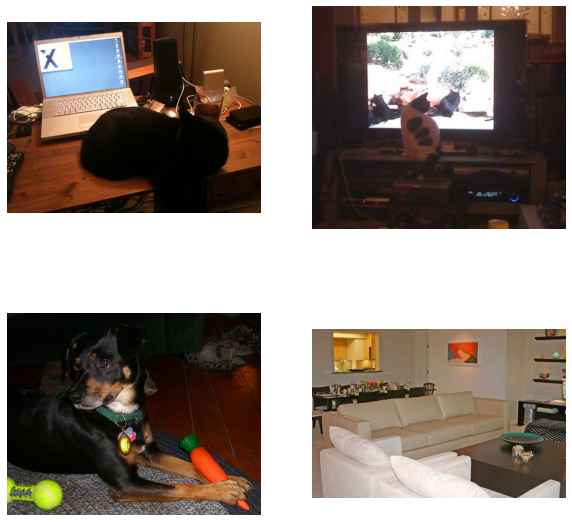

In [8]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), paths_subset):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from tqdm import tqdm

In [11]:
cfg = get_cfg()
#cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

In [12]:
import shutil
input_dir = "InstAwareImgs"
if os.path.isdir(input_dir) is False:
    print('Create path: {0}'.format(input_dir))
    os.makedirs(input_dir)
#!mv /root/.fastai/data/coco_sample/train_sample/* InstAwareImgs/
for file in paths_subset:
  shutil.move(file, 'InstAwareImgs/')

In [13]:
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

In [14]:
for image_path in image_list:
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_scores = outputs["instances"].scores.cpu().data.numpy()
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

In [15]:
!git clone https://github.com/jaschn/02456_DeepLearningProject.git

os.chdir('DeepLearningProject/InstanceColorization')

fatal: destination path 'DeepLearningProject' already exists and is not an empty directory.


In [16]:
import sys
from options.train_options import TestOptions
from models import create_model
from tqdm import tqdm_notebook

In [17]:
from fusion_dataset import Fusion_Testing_Dataset
from util import util
import multiprocessing
multiprocessing.set_start_method('spawn', True)

In [18]:
#torch.backends.cudnn.benchmark = True

In [19]:
sys.argv = [sys.argv[0]]
opt = TestOptions().parse()

In [20]:
save_img_path = opt.results_img_dir
if os.path.isdir(save_img_path) is False:
    print('Create path: {0}'.format(save_img_path))
    os.makedirs(save_img_path)
opt.batch_size = 1
opt.test_img_dir = "../../InstAwareImgs"
dataset = Fusion_Testing_Dataset(opt, -1)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [21]:
dataset_size = len(dataset)
print('#Testing images = %d' % dataset_size)

#Testing images = 20


In [22]:
!sh scripts/download_model.sh

Downloading...
Finish download.
Archive:  checkpoints.zip
replace checkpoints/coco_finetuned_mask_256_ffs/latest_net_GComp.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [23]:
model = create_model(opt)
model.setup_to_test('coco_finetuned_mask_256_ffs')

initialize network with normal
initialize network with normal
initialize network with normal
model [FusionModel] was created
load Fusion model from checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth


In [24]:
count_empty = 0
for data_raw in tqdm_notebook(dataset_loader):
    data_raw['full_img'][0] = data_raw['full_img'][0].cuda()
    if data_raw['empty_box'][0] == 0:
        data_raw['cropped_img'][0] = data_raw['cropped_img'][0].cuda()
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_data = util.get_colorization_data(data_raw['cropped_img'], opt, ab_thresh=0, p=opt.sample_p)
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_input(cropped_data)
        model.set_fusion_input(full_img_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.forward()
    else:
        count_empty += 1
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_forward_without_box(full_img_data)
    model.save_current_imgs(join(save_img_path, data_raw['file_id'][0] + '.png'))
print('{0} images without bounding boxes'.format(count_empty))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


RuntimeError: ignored